[강의 정리 링크](https://sooking87.github.io/gdsc%20ml/gdsc-ml-8/) <br>

+ 코드 리뷰까지 같이 정리하였습니다!

In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
box = pd.read_csv(
    './dataset/train_solution_bounding_boxes (1).csv')
box.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


image    vid_4_1000.jpg
xmin         281.259045
ymin         187.035071
xmax         327.727931
ymax         223.225547
Name: 0, dtype: object
(281, 223)   (327, 187)


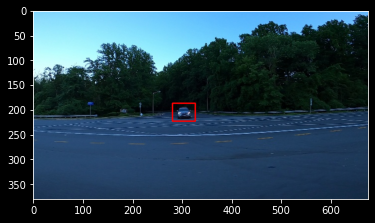

In [4]:
sample = cv2.imread(
    './dataset/training_images/vid_4_1000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
print(point)
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
print(pt1, " ", pt2);
cv2.rectangle(sample, pt1, pt2, color=(255, 0, 0), thickness=2)
plt.imshow(sample)


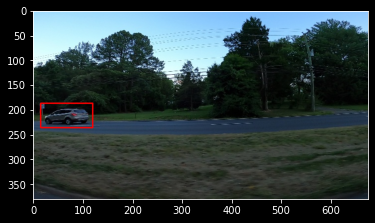

In [5]:
sample = cv2.imread(
    './dataset/training_images/vid_4_10000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[1]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255, 0, 0), thickness=2)
plt.imshow(sample)


In [6]:
# Yolo 로드
# 훈련된 가중치와 네트워크 구성을 저장하고 있는 파일을 불러옴.
net = cv2.dnn.readNet("./yolov3.weights",
                      "./yolov3.cfg")
# 클래스 카테고리를 가져옴.
classes = []
with open("./darknet/data/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
# 레이어 이름 가져오기
layer_names = net.getLayerNames()
# 만들어진 층에서 (13x13, 26x26, 52x52) Layer에 직접 접근해서 feature map 정보를 직접 가져와야 한다.
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


In [7]:
# 이미지 가져오기
img = cv2.imread(
    './dataset/training_images/vid_4_10000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

In [8]:
blob = cv2.dnn.blobFromImage(
    img, 1/256, (416, 416), (0, 0, 0), swapRB=True, crop=False)
net.setInput(blob)

# outs는 출력으로 탐지된 개체에 대한 모든 정보와 위치를 제공한다.
outs = net.forward(output_layers)


In [9]:
# 정보를 화면에 표시
class_ids = []
confidences = []  # 0에서 1까지의 탐지에 대한 신뢰도
boxes = []  # 감지된 개체를 둘러싼 사각형의 좌표
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # 일단 신뢰도 0.5가 넘는 boxes 좌표만 가져오기
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # 좌표
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


22 197 92 32


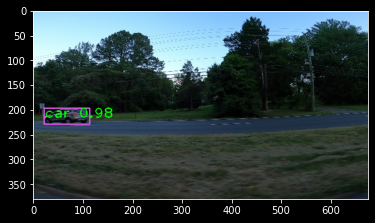

In [10]:
# 동일한 개체에 대한 여러 박스 좌표들 중 제일 신뢰도가 높은 좌표를 제외하고 나머지는 제거하기 위한 코드(NMS)
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(len(boxes), 3))

# 박스, label, confidence를 image 위에 그리는 코드
for i in indexes.flatten():
    x, y, w, h = boxes[i]
    print(x, y, w, h)
    label = str(classes[class_ids[i]])
    confidence = str(round(confidences[i], 2))
    color = colors[i]
    cv2.rectangle(img, (x, y), ((x+w), (y+h)), color, 2)
    cv2.putText(img, label + " " + confidence,
                (x, y+20), font, 2, (0, 255, 0), 2)

plt.imshow(img)


In [11]:
def predict_yolo(img_path):
  # 이미지 가져오기
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  height, width, channels = img.shape

  blob = cv2.dnn.blobFromImage(img, 1/256, (416, 416), (0, 0, 0), swapRB=True, crop=False)
  net.setInput(blob) 
  outs = net.forward(output_layers)

  class_ids = []
  confidences = []
  boxes = []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              # Object detected
              center_x = int(detection[0] * width)
              center_y = int(detection[1] * height)
              w = int(detection[2] * width)
              h = int(detection[3] * height)
              # 좌표
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)
              boxes.append([x, y, w, h])
              confidences.append(float(confidence))
              class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  font = cv2.FONT_HERSHEY_PLAIN
  colors = np.random.uniform(0, 255, size=(len(boxes), 3))
  if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        print(x, y, w, h)
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i], 2))
        color = colors[i]
        cv2.rectangle(img, (x, y), ((x+w), (y+h)), color, 2)
        cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (0, 255, 0), 2)

    plt.imshow(img)
  
  else:
    print('탐지된 물체가 없습니다.')

87 199 104 28


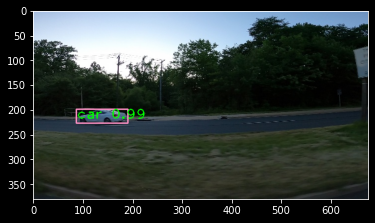

In [15]:
import glob
import random

paths = glob.glob('./dataset/testing_images/*.jpg')

img_path = random.choice(paths)

predict_yolo(img_path)


39 101 20 27
354 186 13 10
315 189 28 22
352 183 13 9
336 177 9 5
324 180 14 7
328 178 10 5


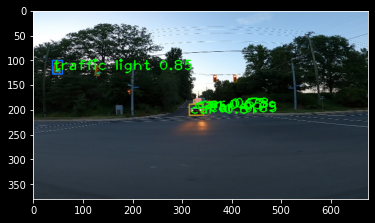

In [16]:
img_path = random.choice(paths)

predict_yolo(img_path)
